# CNN for CIFAR-10 with Data Augmentation and Regularization
In this notebook, we experiement with Keras to implement an CNN to classify CIFAR-10 images while making use of built-in tools for data augmentation and regularization techniques (L2, Dropout, etc.)


---
- We start by importing the dataset, normalizing the data, and one-hot encoding the labels


In [0]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.utils import np_utils

# Import the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Center and normalize the data
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# One-hot encoding of the labels
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

- In order to have more training data, we generate new datapoints using known transformations (rotating, cropping, flipping) that should not affect the label of the datapoint (e.g. a dog does not become a cat). 

**Note:** the ImageDataGenerator provides the option to apply ZCA whitening on the images but it is not used here as accuracies were found to be better without.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# Augment the data with known transformations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)

- We now define our model architecture by stacking layers in a Keras Sequential. 

The Keras **L2 Regularizer** is used in the convolutional layers to prevent the weights of each kernel (i.e. filter) from growing unchecked and overfitting to the data set. 

We opt for the **Exponential Linear Unit** (ELU) as the activation function in an effort to address the "dying ReLU" problem. 

Between each hidden layer of this model, we choose to perform **Batch Normalization** to re-center and re-scale the input to the next layer (effects dicussed in report). 

We then perform **MaxPooling** that halves the input in both spatial direction while keeping the most active unit. 

Our model also implements the **Dropout** regularization technique which randomly deactivates a subset of units during training time.

After all the convolutional and pooling layers, we finally arrive at a **fully-connected layer** (implemented usign Flatten and Dense) to determine the class of the image. 

We use the **Softmax** activation function as it more decisive when it comes to multi-class classification.

In [0]:
# Model and layers
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, MaxPooling2D, Flatten
# Regularization tools
from keras.layers import Dropout
from keras import regularizers

weight_decay = 1e-4
# Instantiate model
model = Sequential()

# Add first convolutional layer 
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Add second convolutional layer
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
# Add third convolutional layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Add fourth convolutional layer
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Add fifth and final convolutional layer
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
# Flatten and add last layer to output predictions
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

- In order to speed up optimization of our model, we choose **RMSprop** gradient descent for its excellent track record in experiemental work as well as its ability to work in small batches.

In [0]:
from keras.callbacks import LearningRateScheduler

# Change the learning rate depending on the current epoch 
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

- We can now train the model

In [12]:
#training
batch_size = 64

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=150,
                    verbose=1, validation_data=(x_test,y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/300
781/781 [==============================] - 33s 43ms/step - loss: 1.8929 - accuracy: 0.4250 - val_loss: 1.3599 - val_accuracy: 0.5953
Epoch 2/300
781/781 [==============================] - 33s 42ms/step - loss: 1.2292 - accuracy: 0.5973 - val_loss: 0.9518 - val_accuracy: 0.7057
Epoch 3/300
781/781 [==============================] - 33s 42ms/step - loss: 1.0474 - accuracy: 0.6648 - val_loss: 1.0917 - val_accuracy: 0.6845
Epoch 4/300
781/781 [==============================] - 33s 42ms/step - loss: 0.9580 - accuracy: 0.6965 - val_loss: 0.8726 - val_accuracy: 0.7428
Epoch 5/300
781/781 [==============================] - 33s 42ms/step - loss: 0.8953 - accuracy: 0.7219 - val_loss: 1.0031 - val_accuracy: 0.7148
Epoch 6/300
781/781 [==============================] - 33s 43ms/step - loss: 0.8483 - accuracy: 0.7402 - val_loss: 0.7355 - val_accuracy: 0.7825
Epoch 7/300
781/781 [==============================] - 33s 42ms/step - loss: 0.8127 - accuracy: 0.7537 - val_loss: 0.8705 - val_ac

- Create acc vs epoch plot

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


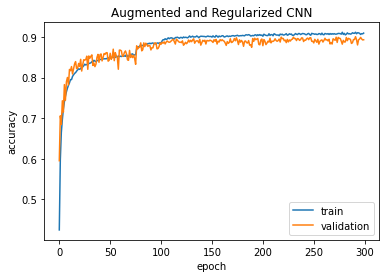

In [13]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Augmented and Regularized CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

- Evaluate the model performance

In [14]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 118us/step

Test result: 89.290 loss: 0.419
